# Topic modeling on scientific literature

In [1]:
#hide_input
import os
import re 

import pdftotext

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

import spacy
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import networkx as nx

FONT = fm.FontProperties(family = 'Times', 
                         fname = '/Library/Fonts/timr45w.ttf',
                         size = 18)
plt.rcParams.update({'font.size': 14, "font.family": "Times"})

In [2]:
PDF_FOLDER = './data/pdf'
MASK_IMAGE_PATH = './images/cloud.png'
OUTPUT_FOLDER = './outputs'

SEED = 0
N_TOPICS = 6
N_WORDS_PER_TOPIC = 50
N_WORDS_HIGHLIGHT_WORDCLOUD = 5

with open('./utils/stop_words_EN.txt', 'r') as f:
    STOP_WORDS = f.read().split('\n')

In [3]:
#hide_input

# Utility functions

def read_pdfs(folder):
    documents = []
    filenames = []
    years = []
    # Load your PDFs
    for f in os.listdir(PDF_FOLDER):
        d = ''
        with open(os.path.join(PDF_FOLDER, f), "rb") as filename:
            if f.split('.')[-1]=='pdf':
                pdf = pdftotext.PDF(filename)
                for i in pdf:
                    d += i + '\n\n'
                y = re.findall(r"(20\d{2})", f)[0]
                years.append(int(y))
                documents.append(d)
                filenames.append(f) 
    return documents, filenames, years

def get_topic_words(pipe, top_n_words=15):
    t_words, word_strengths = {}, {}
    tdidf_features = pipe.named_steps['tfidf'].get_feature_names_out()
    for t_id, t in enumerate(pipe.named_steps['topic_model'].components_):
        t_words[t_id] = [tdidf_features[i] for i in t.argsort()[:-top_n_words - 1:-1]]
        word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
    return t_words, word_strengths

def wordcloud(topic_i_word_importances, keywords, ax, plot_title=False):
    # Generate mask based on image
    mask = np.array(Image.open(MASK_IMAGE_PATH))
    mask = np.where(mask>220, 255, mask)
    image_colors = ImageColorGenerator(mask)

    # Func to highlight keyword
    def keyword_colorize(word, font_size, position, orientation, random_state=None,
                        **kwargs):
        if word in keywords:
            return "rgb(0, 0, 255)"
        else:
            return image_colors(word=word, font_size=font_size, position=position, 
                                orientation=orientation, random_state=None, **kwargs) 

    # Generate word cloud object
    wc = WordCloud(background_color="white", max_words=100, mask=mask)
    wc.generate_from_frequencies(topic_i_word_importances)

    # Plot image
    ax.imshow(wc.recolor(color_func=keyword_colorize), interpolation="bilinear")
    ax.axis("off") # remove axis 
    if plot_title:
        ax.set_title(plot_title, fontsize=24, fontproperties = FONT)

## Load documents

In [4]:
documents, filenames, years = read_pdfs(PDF_FOLDER)
    
print(f'{len(documents)} PDFs loaded as text.')

19 PDFs loaded as text.


## Preprocessing

In [5]:
%%time

nlp = spacy.load("en_core_web_sm")

docs = []

# Filter lemmas for tokens in ['ADJ', 'VERB', 'NOUN', 'PROPN']
for doc in nlp.pipe(documents):
    filtered = ' '.join([token.lemma_ for token in doc if token.pos_ in ['ADJ', 'VERB', 'NOUN', 'PROPN']])
    docs.append(filtered)

CPU times: user 37.4 s, sys: 10.5 s, total: 47.9 s
Wall time: 1min 9s


## Topic model

In [6]:
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.90, min_df=2,
                              max_features=1000,
                              stop_words=STOP_WORDS,
                              token_pattern=r'(?u)\b[A-Za-z]+\b',
                              ngram_range=(1, 3))),
    ('topic_model', NMF(N_TOPICS, 
                        max_iter=1000,
                        random_state=1))
])

In [7]:
pipe.fit(docs)

/Users/adelsondias/miniconda3/envs/ca-prototype/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=1000, min_df=2,
                                 ngram_range=(1, 3),
                                 stop_words=['ll', 'tis', 'twas', 've', '000',
                                             '00', 'a', 'as', 'able',
                                             'ableabout', 'about', 'above',
                                             'abroad', 'abst', 'accordance',
                                             'according', 'accordingly',
                                             'across', 'act', 'actually', 'ad',
                                             'added', 'adj', 'adopted', 'ae',
                                             'af', 'affected', 'affecting',
                                             'affects', 'after', ...],
                                 token_pattern='(?u)\\b[A-Za-z]+\\b')),
                ('topic_model',
                 NMF(max_iter=1000, n_components=6, random_stat

## Analysis

### a. What are some prominent topics in the literature?

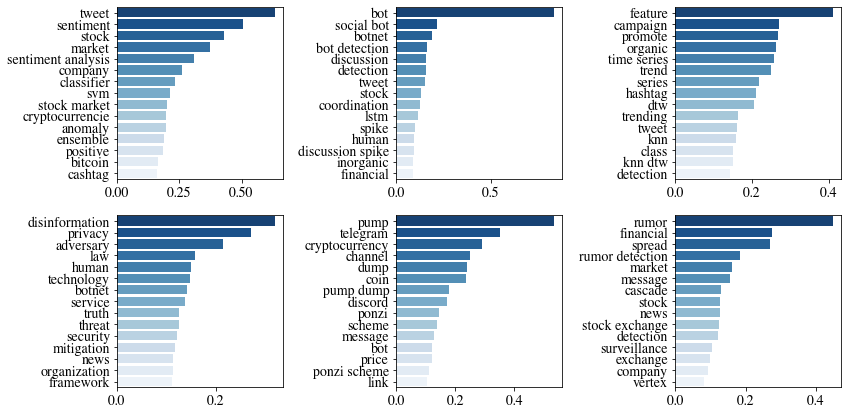

In [8]:
#hide_input

topic_words, words_importance = get_topic_words(pipe, 15)

nrows = int(np.ceil(N_TOPICS/3))
fig, ax = plt.subplots(figsize=(12,3*nrows), ncols=3, nrows=nrows)

plt.subplots_adjust(
    wspace  =  0.5,
    hspace  =  0.5
)

c=0
for row in range(0, nrows):
    for col in range(0,3):
        
        try:
            sns.barplot(x=words_importance[c], y=topic_words[c], palette="Blues_r", ax=ax[row][col])
        except:
            pass
        c+=1
        if c>N_TOPICS:
            ax[row][col].axis('off')
        
plt.tight_layout()
fig.savefig(os.path.join(OUTPUT_FOLDER, 'topics_barplot.png'), facecolor='#fff', dpi=300) 
plt.show()

In [9]:
#hide_input_output
topic_words, words_importance = get_topic_words(pipe, N_WORDS_PER_TOPIC)

tw = pd.DataFrame(topic_words).melt(var_name='topic_id', value_name='word')
wi = pd.DataFrame(words_importance).melt(var_name='topic_id', value_name='importance')

topic_word_importance = pd.concat([tw,wi['importance']], axis=1)
topic_word_importance = topic_word_importance.set_index(['topic_id', 'word'])
topic_word_importance.sample(5)

,,importance
topic_id,word,
0,price,0.145109
2,detection,0.141785
3,human,0.149593
5,source,0.046277
3,download,0.089857


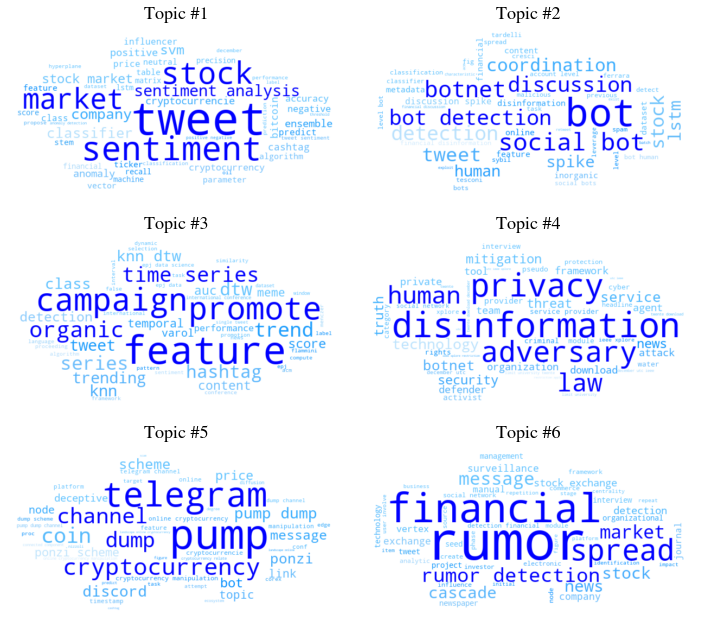

In [10]:
#hide_input

nrows = int(np.ceil(N_TOPICS/2))
fig, ax = plt.subplots(figsize=(10,3*nrows), ncols=2, nrows=nrows)

c=0
for row in range(0, nrows):
    for col in range(0,2):
        topic_i_word_importances = topic_word_importance.loc[c, 'importance']
        wordcloud(topic_i_word_importances.to_dict(), 
                  keywords=topic_i_word_importances.sort_values()[-N_WORDS_HIGHLIGHT_WORDCLOUD:], 
                  ax=ax[row][col],
                  plot_title=f'Topic #{c+1}')
        c+=1
        if c>N_TOPICS:
            ax[row][col].axis('off')
                
fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_FOLDER, 'wordcloud.pdf'), facecolor='#fff', dpi=300) 
plt.show()

In [11]:
# Given SEED=0, 

TOPIC_LABELS = {
    1: 'Sentiment analysis',
    2: 'Bot detection',
    3: 'Campaign promotion',
    4: 'Disinformation and privacy',
    5: 'Pumps and dumps',
    6: 'Rumor spreading'
}

In [12]:
docs_topics = pd.DataFrame(pipe.transform(docs), 
                           columns=list(TOPIC_LABELS.values()),
                           index=filenames)
docs_topics

,Sentiment analysis,Bot detection,Campaign promotion,Disinformation and privacy,Pumps and dumps,Rumor spreading
Ibrahim - 2021 - Forecasting the early market movement in bitcoin using twitter's sentiment analysis An ensemble-based prediction model.pdf,0.469492,0.000000,0.000000,0.041820,0.041896,0.000000
"Lange, Kettani - 2019 - On Security Threats of Botnets to Cyber Systems.pdf",0.000000,0.251676,0.000000,0.267881,0.000000,0.000000
Sela et al - 2020 - Using connected accounts to enhance information spread in social networks.pdf,0.000000,0.140555,0.015975,0.000000,0.069932,0.620700
Kudugunta - 2018 - Deep neural networks for bot detection.pdf,0.076697,0.580714,0.072897,0.000000,0.000000,0.000000
Geckil et al. - 2018 - A clickbait detection method on news sites.pdf,0.085922,0.000000,0.183729,0.326146,0.035637,0.103153
Tardelli et al. - 2020 - Characterizing Social Bots Spreading Financial Disinformation.pdf,0.028358,0.750603,0.000000,0.000000,0.000000,0.060125
Khaund et al. - 2021 - Social Bots and Their Coordination During Online Campaigns A Survey.pdf,0.000000,0.726069,0.000000,0.095858,0.030996,0.000000
Mahmood - 2019 - Antidatamining framework - Better privacy on Online Social Networks and Beyond.pdf,0.000000,0.007458,0.000000,0.642140,0.005048,0.000000
Dogan et al. - 2020 - Speculator and Influencer Evaluation in Stock Market by Using Social Media.pdf,0.509662,0.000000,0.000000,0.078509,0.000000,0.057278
Nizzoli et al. - 2020 - Charting the Landscape of Online Cryptocurrency Manipulation.pdf,0.000000,0.054760,0.000000,0.000000,0.826464,0.000000


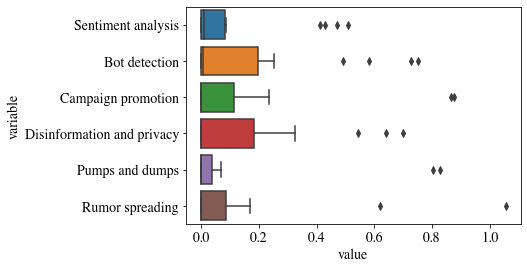

In [13]:
sns.boxplot(data=docs_topics.melt(), y='variable', x='value')

### b. How those themes are connected to each other?

In [14]:
#hide_input

co_occurrences = np.zeros([N_TOPICS, N_TOPICS])

CO_OCCURRENCE_THRESHOLD = docs_topics.stack().quantile(3/4)

for ix, o in (docs_topics>=CO_OCCURRENCE_THRESHOLD).iterrows():
    for i, ti in enumerate(docs_topics.columns):
        for j, tj in enumerate(docs_topics.columns):
            if ti!=tj and o[ti] and o[tj]:
                co_occurrences[i][j] += 1

co_occurrences = pd.DataFrame(co_occurrences, 
                              index=docs_topics.columns,
                              columns=docs_topics.columns)

co_occurrences

,Sentiment analysis,Bot detection,Campaign promotion,Disinformation and privacy,Pumps and dumps,Rumor spreading
Sentiment analysis,0.0,0.0,2.0,1.0,0.0,2.0
Bot detection,0.0,0.0,1.0,2.0,0.0,2.0
Campaign promotion,2.0,1.0,0.0,1.0,0.0,2.0
Disinformation and privacy,1.0,2.0,1.0,0.0,0.0,1.0
Pumps and dumps,0.0,0.0,0.0,0.0,0.0,0.0
Rumor spreading,2.0,2.0,2.0,1.0,0.0,0.0


Node sizes: {'Sentiment analysis': 5000, 'Bot detection': 6000, 'Campaign promotion': 5000, 'Disinformation and privacy': 6000, 'Pumps and dumps': 2000, 'Rumor spreading': 5000}
Tip: Draw this in another software (e.g. draw.io) if you wish a prettier representation.


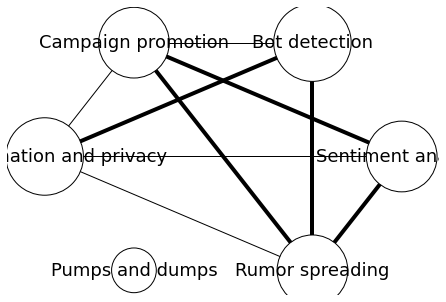

In [15]:
#hide_input

G = nx.Graph()

nodes_sizes = {}
for ix, i in co_occurrences.iterrows():
    G.add_node(ix, color='black')
    nodes_sizes[ix] = (docs_topics[ix]>CO_OCCURRENCE_THRESHOLD).sum()*1000
    for jx, val in i.iteritems():
        G.add_edge(ix, jx, color='black', weight=val**2)

pos = nx.circular_layout(G)

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]

print('Node sizes:', nodes_sizes)
nodes_sizes = [nodes_sizes[t] for t in list(G.nodes)]

nx.draw(G, pos, edge_color=colors, width=weights, with_labels=True, 
        node_color="white", edgecolors= "black",
        node_size=nodes_sizes,
        font_size=18)

print('Tip: Draw this in another software (e.g. draw.io) if you wish a prettier representation.')

### c. How frequent those themes were addressed over time?

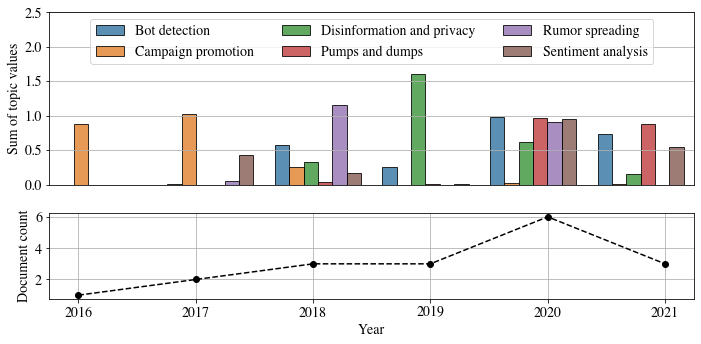

In [16]:
#hide_input
docs_topics2 = docs_topics.melt(var_name='Topic', value_name='Topic value')

docs_topics2['Year'] = years*N_TOPICS
docs_topics2 = docs_topics2.loc[docs_topics2['Year']<=2021]


fig, ax = plt.subplots(nrows=2, figsize=(10,5),
                       gridspec_kw={'height_ratios': [2, 1]})

# Plot the sum of topic values over time
docs_topics3 = docs_topics2.groupby(['Topic', 'Year']).sum().reset_index()
sns.barplot(data=docs_topics3, y='Topic value', x='Year', hue='Topic', 
            ax=ax[0], alpha=.8, edgecolor='black',
            order=[2016, 2017, 2018, 2019, 2020, 2021])

ax[0].set_xticks([])
ax[0].set_xlabel('')
ax[0].set_ylim([0, 2.5])
ax[0].set_ylabel('Sum of topic values')

# Plot the aggregated number of documents over time
pd.Series(years).value_counts().drop(2022)\
    .sort_index().plot(ax=ax[1], color='black', linestyle='--', marker='o')

ax[0].legend(ncol=3, loc='upper center')
ax[0].grid()
ax[1].grid()
ax[1].set_ylabel('Document count')
ax[1].set_xlabel('Year')

fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_FOLDER, 'topics_over_time.png'), dpi=300)